# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 
**Целью данного проекта будет построить модель для определения стоимости автомобиля.**

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

На первом этапе импортируем библиотеки, которые потребуются нам для работы, а также проведём первичный осмотр и анализ данных.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Наши признаки:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:** 

- Price — цена (евро)

Мы видим, что в данных присутствуют пропуски. Поочерёдно более детально исследуем каждый столбец, разбираясь поэтапно с пропусками и аномалиями в данных. Приведём данные к нужным типам (где потребуется). Переименуем столбцы для удобства работы с ними.

In [5]:
data = data.rename(columns={'DateCrawled':'date_crawled', 'VehicleType':'vehicle_type', 
                            'RegistrationYear':'registration_year', 'Gearbox':'gearbox', 'Power':'power', 'Model':'model', 
                            'Kilometer':'kilometer', 'RegistrationMonth':'registration_month', 'FuelType':'fuel_type', 
                            'Brand':'brand', 'Repaired':'repaired', 'DateCreated':'date_created', 
                            'NumberOfPictures':'number_of_pictures', 'PostalCode':'postal_code', 'LastSeen':'last_seen', 
                            'Price':'price'})

Не все столбцы понадобятся нам для работы, оставим только те, которые непосредственно влияют на стоимость автомобиля, затем приступим к предобработке данных.

In [6]:
data = data.drop(['date_crawled', 'date_created', 'registration_month', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Можно заметить аномальные значения в этом столбце. Установим границу для даты регистрации автомобиля. 

Нижней границей поставим 1930 год и посмотрим с помощью графика на выбросы.

<AxesSubplot:>

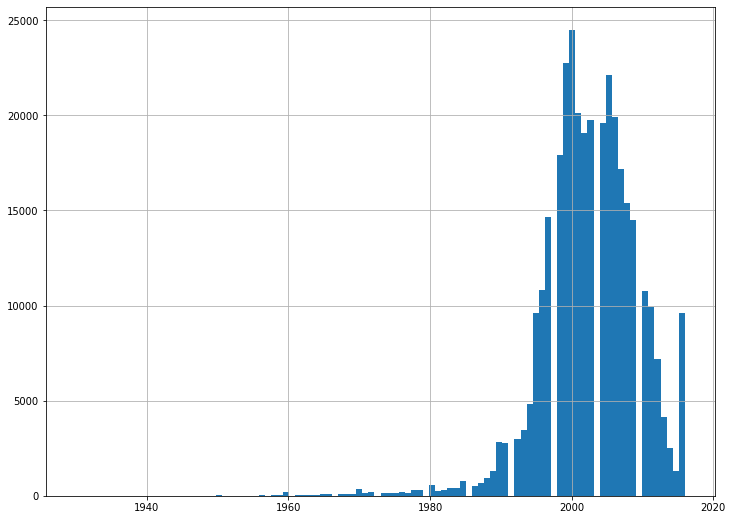

In [8]:
data = data.query('1930 <= registration_year <= 2016') 
data['registration_year'].hist(bins=100, figsize=(12,9))

Нижней границей даты регистрации автомобиля оставим 1970 год.

In [9]:
data = data.query('1970 <= registration_year <= 2016') 

In [10]:
data['price'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,price
0,9858
1,1093
2,10
3,7
4,1
...,...
19995,10
19997,1
19998,6
19999,272


Мы можем видеть аномальные значения в столбце с целевым признаком. Цену меньше 500 евро за автомобиль будем считать ошибкой в данных. Удалим эти значения, так как в ином случае они могут некорректно повлиять на работу моделей. 

In [11]:
data = data.query('price >= 500')
data['price'].unique()

array([18300,  9800,  1500, ..., 12395, 18429, 10985])

In [12]:
data['vehicle_type'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,vehicle_type
bus,27809
convertible,19444
coupe,14674
other,2709
sedan,85070
small,68195
suv,11639
wagon,60703
NaN,13981


Заполним пропуски наиболее популярным типом кузова - это седан.

In [13]:
data.fillna({'vehicle_type':'sedan'}, inplace=True)
data['vehicle_type'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,vehicle_type
bus,27809
convertible,19444
coupe,14674
other,2709
sedan,99051
small,68195
suv,11639
wagon,60703


In [14]:
data['gearbox'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,gearbox
auto,61404
manual,231206
NaN,11614


Добавим пропущенные значения механическую коробку передач, так как это наиболее популярное значение.

In [15]:
data.fillna({'gearbox':'manual'}, inplace=True)
data['gearbox'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,gearbox
auto,61404
manual,242820


In [16]:
data['power'].unique()

array([  190,   163,    75,    69,   102,   109,   125,   101,   105,
         140,   115,   131,   136,   160,   231,   118,   193,    99,
          50,    60,   113,   218,   122,     0,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   232,   150,   156,
          80,    82,    90,   185,    87,   180,    86,    84,   224,
         235,   200,   178,   265,    77,   110,   120,    54,   286,
         116,   184,   126,   204,    88,   194,    64,   305,   197,
         179,   250,    45,   313,    41,   165,    98,   130,   114,
         211,    56,   201,   213,   107,    83,   174,   100,   220,
          73,   192,    68,    66,   299,    74,    58,    52,   147,
         310,    71,    97,    65,   239,   203,     5,   144,   300,
         103,    85,   258,   320,    63,    81,   148,    44,   145,
         280,   260,   104,   188,   333,   186,   117,   141,   132,
         155,   234,   158,    39,    92,    51,   135,    59,   230,
         209,    43,

В столбце с мощностью автомобиля можно также заметить аномальные значения - нулевая мощность и слишком большая мощность. Возьмём минимальное значение мощности 100 л.с., а максимальное - 4000 (2028 л.с. для легковых авто, 4000 для грузовых).

In [17]:
data = data.query('50 <= power <= 2000') 
data['power'].unique()

array([ 190,  163,   75,   69,  102,  109,  125,  101,  105,  140,  115,
        131,  136,  160,  231,  118,  193,   99,   50,   60,  113,  218,
        122,  129,   70,  306,   95,   61,  177,  170,   55,  143,  232,
        150,  156,   80,   82,   90,  185,   87,  180,   86,   84,  224,
        235,  200,  178,  265,   77,  110,  120,   54,  286,  116,  184,
        126,  204,   88,  194,   64,  305,  197,  179,  250,  313,  165,
         98,  130,  114,  211,   56,  201,  213,  107,   83,  174,  100,
        220,   73,  192,   68,   66,  299,   74,   58,   52,  147,  310,
         71,   97,   65,  239,  203,  144,  300,  103,   85,  258,  320,
         63,   81,  148,  145,  280,  260,  104,  188,  333,  186,  117,
        141,  132,  155,  234,  158,   92,   51,  135,   59,  230,  209,
        146,   67,  106,  166,  276,  344,   72,  249,  237,  245,  111,
        326,  279,  138,  175,   96,  226,  301,  334,  128,  133,  124,
        219,  241,  167,   94,  182,  196,  238, 13

In [18]:
data['model'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,model
100,323
145,24
147,481
156,481
159,196
...,...
yeti,171
ypsilon,147
z_reihe,683
zafira,2491


Заменим пропущенные значения в этом столбце на 'unknown'.

In [19]:
data.fillna({'model':'unknown'}, inplace=True)
data['model'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,model
100,323
145,24
147,481
156,481
159,196
...,...
yaris,911
yeti,171
ypsilon,147
z_reihe,683


In [20]:
data['kilometer'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,kilometer
5000,2232
10000,832
20000,3032
30000,3683
40000,4357
50000,5458
60000,6597
70000,7539
80000,8678
90000,9837


In [21]:
data['fuel_type'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,fuel_type
cng,466
electric,31
gasoline,86432
hybrid,199
lpg,4579
other,47
petrol,171085
NaN,12404


Заполним пропуски в столбце, взяв за основу самый популярный тип топлива.

In [22]:
data.fillna({'fuel_type':'petrol'}, inplace=True)
data['fuel_type'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,fuel_type
cng,466
electric,31
gasoline,86432
hybrid,199
lpg,4579
other,47
petrol,183489


In [23]:
data['brand'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,brand
alfa_romeo,1855
audi,24997
bmw,31568
chevrolet,1424
chrysler,1101
citroen,3915
dacia,799
daewoo,329
daihatsu,472
fiat,6565


In [24]:
data['repaired'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,repaired
no,216490
yes,22785
NaN,35968


Добавим пропущенные значения в этом столбце в ответ 'no', так как можно предположить, что продавцы, не ремонтировавшие машины, пропускали этот ответ.

In [25]:
data.fillna({'repaired':'no'}, inplace=True)
data['repaired'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,repaired
no,252458
yes,22785


Выделим признаки, разобьём данные на выборки и проведём кодирование категориальных признаков.

In [26]:
features = data.drop(['price'], axis=1)
target = data['price']

In [27]:
#разделим наш датасет на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [28]:
# закодируем признаки 

categorial = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'] # выделим категориальные признаки

encoder = OrdinalEncoder()

features_train[categorial] = encoder.fit_transform(features_train[categorial])
features_test[categorial] = encoder.fit_transform(features_test[categorial])

## Обучение моделей

**Проверим в работе следующие модели:**

- CatBoostRegressor
- DecisionTreeRegressor
- RandomForestRegressor
- LightGBM 

**Нашей задачей будет рассчитать метрику RMSE, а также замерить время обучения и время предсказания каждой модели.**

In [29]:
%%time

parameters = [{'learning_rate':[0.1, 0.5, 0.8]}]

model = CatBoostRegressor(loss_function='RMSE', random_state=12345, verbose=False) 
cat_model = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
cat_model = cat_model.fit(features_train, target_train)

print('CatBoostRegressor:', mean_squared_error(target_train, cat_model.predict(features_train), squared=False))
print('Лучшие параметры:', cat_model.best_params_)

CatBoostRegressor: 1357.88565394113
Лучшие параметры: {'learning_rate': 0.5}
CPU times: user 6min 34s, sys: 2.7 s, total: 6min 37s
Wall time: 6min 53s


In [30]:
%%time

model = CatBoostRegressor(learning_rate=0.5, loss_function='RMSE', random_state=12345, verbose=False) 
cat_model_train_time = model.fit(features_train, target_train)

CPU times: user 30.6 s, sys: 232 ms, total: 30.8 s
Wall time: 31.9 s


In [31]:
%%time

cat_model_prediction_time = cat_model.predict(features_train)

CPU times: user 226 ms, sys: 3.93 ms, total: 229 ms
Wall time: 235 ms


In [32]:
%%time

parameters = [{'max_depth': range(1, 15)}]

model = DecisionTreeRegressor(random_state=12345)

tree_model = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
tree_model = tree_model.fit(features_train, target_train)

print('DecisionTreeRegressor:', mean_squared_error(target_train, tree_model.predict(features_train), squared=False))
print('Лучшие параметры:', tree_model.best_params_)

DecisionTreeRegressor: 1485.5324945707007
Лучшие параметры: {'max_depth': 14}
CPU times: user 18.6 s, sys: 31.8 ms, total: 18.6 s
Wall time: 18.6 s


In [33]:
%%time

model = DecisionTreeRegressor(max_depth=16, random_state=12345)
tree_model_train_time = model.fit(features_train, target_train)

CPU times: user 591 ms, sys: 0 ns, total: 591 ms
Wall time: 597 ms


In [34]:
%%time

tree_model_prediction_time = tree_model.predict(features_train)

CPU times: user 51.3 ms, sys: 0 ns, total: 51.3 ms
Wall time: 55.4 ms


In [35]:
%%time

parameters = [{'n_estimators': range(1, 30), 'max_depth': range(1, 8)}]

model = RandomForestRegressor(random_state=12345)

forest_model = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
forest_model = forest_model.fit(features_train, target_train) 

print('RandomForestRegressor:', mean_squared_error(target_train, forest_model.predict(features_train), squared=False))
print('Лучшие параметры:', forest_model.best_params_)

In [36]:
%%time

model = RandomForestRegressor(n_estimators=24, max_depth=7, random_state=12345)
forest_model_train_time = model.fit(features_train, target_train)

In [37]:
%%time

forest_model_prediction_time = forest_model.predict(features_train)

In [38]:
%%time

parameters = [{'learning_rate':[0.1, 0.5, 0.8], 'n_estimators' : range(1, 15), 'random_state':[12345]}]

model = LGBMRegressor()
lgbmr_model = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
lgbmr_model = lgbmr_model.fit(features_train, target_train)

print('LGBMRegressor:', mean_squared_error(target_train, lgbmr_model.predict(features_train), squared=False))
print('Лучшие параметры:', lgbmr_model.best_params_)

In [39]:
%%time

model = LGBMRegressor(learning_rate=0.5, n_estimators=14, random_state=12345)
lgbmr_model_train_time = model.fit(features_train, target_train)

In [40]:
%%time

lgbmr_model_prediction_time = lgbmr_model.predict(features_train)

## Анализ моделей

**Посмотрим, какие результаты показали наши модели.** 

Лучший результат показала модель CatBoostRegressor: RMSE - **1357.88565394113**. Время обучения - 30.6 s, время предсказания - 226 ms.

Модель **дерева решений в регрессии**: RMSE - 1485.5324945707007. Время обучения - 591 ms, время предсказания - 51.3 ms.

Модель **случайного леса в регрессии**: RMSE - 2120.590165704048. Время обучения - 6.18 s, время предсказания - 314 ms.

Модель **LGBMRegressor**: RMSE - 1753.3677156424444. Время обучения - 32.3 s, время предсказания - 284 ms.

Проверим модель с лучшими гиперпараметрами на тестовой выборке. 

In [41]:
model = CatBoostRegressor(learning_rate=0.5, random_state=12345, verbose=False) 
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = mean_squared_error(predictions, target_test, squared=False) 

print('Лучший показатель модели CatBoostRegressor на тестовой выборке:', result)

Лучший показатель модели CatBoostRegressor на тестовой выборке: 1680.8347583198067


# Подведём итоги работы 

В ходе работы над проектом мы выполнили следующие шаги:

- загрузили и проанализировали данные, выполнили предобработку данных;
- выделили признаки и провели кодирование категориальных признаков;
- сравнили четыре модели с разными наборами гиперпараметров;
- нашли лучшую модель по результатам метрики RMSE и проверили её на тестовой выборке.

- **Лучший результат показала модель CatBoostRegressor: RMSE 1357.88565394113 на обучающей выборке и 1680.8347583198067 на тестовой.** 

**Лучшее время показала модель DecisionTreeRegressor. Время обучения - 591 ms, время предсказания - 51.3 ms. При этом результат метрики RMSE - 1485.5324945707007.**